In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [211]:
import logging
from pathlib import Path
import textwrap
import copy
from PIL import Image, ImageDraw, ImageFont
from waveshare_epd import epd2in7b
from waveshare_epd import epd5in83

In [268]:
import random

In [5]:
import constants


In [6]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

In [7]:
class TextBlock:
    '''Class for creating a 1 bit image of word-wrapped text
    
    Args
    ----
        resolution (int, int): tuple of ints representing maximum resolution of image
        text (str): text to format into image
        font (str): path to ttf font
        size (int): size of font in points (pixles)
        max_lines (int): maximum number of wrapped rows of text; surplus is discarded
        maxchar (int): maximum number of characters per row
            this is automatically calculated if not specified based on font face, font size
            and letter frequency (see chardist below)
        chardist (dict): character frequency distribution for a particular language
            provided distributions in constants.py: 
            USA_CHARDIST+, FRA_CHARDIST, DEU_CHARDIST, PRT_CHARDIST, ITA_CHARDIST, TUR_CHARDIST,
            SWE_CHARDIST, NED_CHARDIST, DAN_CHARDIST
                + only USA english includes upper and lower case characters
        coordinates (int, int): location on screen image should be positioned (not used locally)
    
    Attributes
    ----------
        resolution (int, int): max resolution of image in px
        font (ImageFont.trueType): font and size to use
        maxchar (int): maximum number of characters per row
        max_lines (int): maximum number of wrapped rows of text; surplus is discarded
        coordinates (int, int): position of text in final image (not used in this class)
        size (int, int): size of text image in px
        text (str): raw text
        formatted (str): wrapped text
        textimage (ImageDraw.Draw): 1 bit image containing formatted text text


    '''
    def __init__(self, resolution=(600, 448), text=' ', font=constants.FONT, size=24, max_lines=3,
                 maxchar=None, center=False, coordinates=(0, 0), chardist=constants.USA_CHARDIST):
        self.resolution=resolution
        self.font = ImageFont.truetype(str(Path(font).absolute()), size)
        self._chardist = chardist
        self.maxchar = maxchar
        self.center = center
        self.dimensions = (0, 0)
        self.max_lines = max_lines
        self.coordinates = coordinates
        self.image = None
        self.text = text
    
        
    @property
    def resolution(self):
        '''maximum resolution in for image
        
        ::2-tuple of int'''
        return self._resolution
    
    @resolution.setter
    def resolution(self, resolution):
#         for r in resolution:
#             if not isinstance(r, int):
#                 raise TypeError(f'resolution must be type int: {r}')
#             if r < 0:
#                 raise ValueError(f'resolution must be positive: {r}')
        if self.coordcheck(resolution):
            self._resolution = resolution
        else:
            raise ValueError(f'bad resolution value: {resolution}')
    
    @property
    def coordinates(self):
        '''coordinates to place the formatted text within the final image (not used in this method)
        
        ::2 tuple of int'''
        return self._coordinates
    
    @coordinates.setter
    def coordinates(self, coordinates):
        if self.coordcheck(coordinates):
            self._coordinates = coordinates
        else:
            raise ValueError(f'bad coordinate values: {coordinates}')
    
    @property
    def maxchar(self):
        '''maximum number of characters per row
            if no value is set this is calculated based on font face, font size and letter frequency
            
        ::int'''
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if maxchar:
            self.__maxchar = maxchar
            return(maxchar)
        else:
            s = ''
            n = 1000 # sample string size for measuring
            # create a string of characters containing the letter distribution
            for char in self._chardist:
                s = s+(char*int(self._chardist[char]*n))
            sLenPX = self.font.getsize(s)[0] # string length in Pixles
            avgCharLen = sLenPX/len(s)
            maxchar = round(self.resolution[0]/avgCharLen)
            self._maxchar = maxchar
            logging.debug(f'maximum characters/line: {maxchar}')
    
    @property
    def text(self):
        '''raw text
        
        ::str'''
        return self._text
    
    @text.setter
    def text(self, text):
        if not text:
            self.text = None
        else:
            self._text = text
            self.formatted = self.formattext()
            self.image = self.textimage()
    
    @property
    def max_lines(self):
        '''maximum number of rows to use when wrapping text
        
        ::int'''
        return self._max_lines
    
    @max_lines.setter
    def max_lines(self, max_lines):
        if max_lines < 1:
            raise ValueError(f'max_lines must be greater than 0: {max_lines}')
        if not isinstance(max_lines, int):
            raise ValueError(f'max_lines must be type integer: {max_lines}')
        self._max_lines = max_lines
    
    def formattext(self, text=None, maxchar=None, max_lines=None):
        '''format text using word-wrap strategies
        
        Args
        ----
            text (str): raw text
            maxchar (int): maximum number of characters in each row
            max_lines (int): maximum number of rows
            justify (str): 'l'-left (default), 'c'-center
            
        Returns
        -------
            ::list of ::str'''
        
        if not maxchar:
            maxchar = self.maxchar
        if not max_lines:
            max_lines = self.max_lines
        if not text:
            text = self.text

        wrapper = textwrap.TextWrapper(width=maxchar, max_lines=max_lines)
        myText = wrapper.wrap(text)
        
        # pad out unused lines in max_lines
        if len(myText) < max_lines:
            for i in range(len(myText), max_lines):
                myText.append(" ")
        
        logging.debug(f'total lines: {len(myText)}')
        
        logging.debug(myText)
    
        
        return(myText)
    
    def textimage(self, text=None, coordinates=None, center=None):
        '''produces 1 bit image of containing wrapped text
        
        Args
        ----
            text (str): raw text to use; if none is provided use self.formatted
            coordinates (int): coordinates of text in final image (not used in this class)
            
        Returns
        -------
            ::Image.new()'''
        if text:
            formatted = self.formattext(text)
        else:
            formatted = self.formatted
        
        if center is None:
            center = self.center
        
        if not coordinates:
            coordinates = self.coordinates
        
        tallest = self.font.getsize('Q')[1]
        current_h = 0
        pad = 0
        current_w = 0
        # determine the dimensions of each line of text and total dimensions
        for line in formatted:
            w, h = self.font.getsize(line)
            current_h += h + pad # accumulate the total height
            if w > current_w: # find the longest line
                current_w = w 
        dimensions = (current_w, current_h)
        logging.debug(f'text dimension: {dimensions}')
        self.dimensions = dimensions
        image = Image.new('1', dimensions, 255)
        draw = ImageDraw.Draw(image)
        current_h = 0
        y_pos = 0
        # loop through the lines again to build the image
        for line in self.formatted:
            w, h = self.font.getsize(line)
            if center:
                y_pos = (dimensions[0]-w)/2
            draw.text((y_pos, current_h), line, font=self.font)
            current_h += h + pad
        
        if center:
            new_coordinates = [round(self.resolution[0]/2-self.dimensions[0]/2)+self.coordinates[0], 
                               self.coordinates[1]]
            try:
                self.coordinates = new_coordinates
            except ValueError as e:
                logger.warning(f'error when attempting to center text: {e}')
                logger.warning(f'retrying with non-centered text')
                image = self.textimage(text, coordinates, center=False)
        
        return image

    def coordcheck(self, coordinates):
        for index, c in enumerate(coordinates):
            if not isinstance(c, int):
                raise TypeError(f'coordinate must be type int: '(index, c))
                return False # redundant
            if c < 0:
                raise ValueError(f'coordinate must be positive: ', (index, c))
                return False # redundant
        return True

In [8]:
class CoverArt:
    def __init__(self, image=None, resolution=(1, 1), coordinates=(0,0)):
        self.resolution = resolution
        self.coordinates = coordinates
        self.image = image
        
    @property
    def image(self):
        return self._image
    
    @image.setter
    def image(self, image):
        im = Image.open(image)
        myImage = im.convert(mode='L', colors=2)
        myImage = myImage.resize((self.resolution))
        self._image = myImage
        
        
        
    

In [9]:
class Screen:
    def __init__(self, resolution=(600, 448), elements=[], epd=None):
        self.resolution = resolution
        self.elements = elements
        self.image = self.clearScreen()
        self.epd = epd
        
    @property
    def resolution(self):
        return self._resolution
    
    @resolution.setter
    def resolution(self, resolution):
        if self.coordcheck(resolution):
            self._resolution = resolution
    
    def clearScreen(self):
        '''sets base image for building screen to an empty background'''
        self.image = Image.new('L', self.resolution, 255)
        return self.image

    def concat(self, elements=None):
        if elements:
            elements = elements
        else:
            elements = self.elements
    
        for e in self.elements:
            self.image.paste(e.image, (e.coordinates))
        return(self.image)
        
    def coordcheck(self, coordinates):
        for c in coordinates:
            if not isinstance(c, int):
                raise TypeError(f'coordinate must be type int: {c}')
                return False # redundant
            if c < 0:
                raise ValueError(f'coordinate must be positive: {c}')
                return False # redundant
        return True        
    
    def initEPD(self):
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
            self.epd.init()
        except Exception as e:
            logging.error(f'failed to init epd: {e}')
    
    def clearEPD(self):
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
            self.epd.Clear();
        except Exception as e:
            logging.error(f'failed to clear epd: {e}')
    
    def writeEPD(self, image=None, sleep=True):
        epd = self.epd
        if not self.epd:
            raise UnboundLocalError('no epd object has been assigned')
        try:
#             epd.display(epd.getbuffer(self.image), epd.getbuffer(Image.new('1', (epd.height, epd.width), 255)))
            epd.display(epd.getbuffer(self.image))
            if sleep:
                epd.sleep()
        except Exception as e:
            logging.error(f'failed to write to epd: {e}')
        
        

In [10]:
class Layout:
    def __init__(self, resolution=(600, 448), layout=None):
        self.resolution = resolution
        self.layout = layout

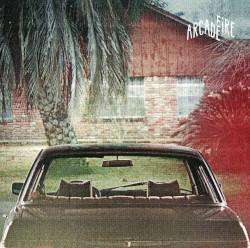

In [20]:
ca = Image.open('./cover.jpg')

In [599]:
def scalefont(font=constants.FONT, lines=1, text=None, resolution=(100, 100), chardist=constants.USA_CHARDIST,  char=15,):
    
    resolution = (resolution[0], round(resolution[1]/lines))
    print(resolution)
    
    # generate n random characters rougly matching the letter frequency in the distribution map
    s = ''
    n = 1000 # sample string size for measuring
    # create a string of characters containing the letter distribution
    for c in chardist:
        s = s+(c*int(chardist[c]*n))
    text = ("".join(choices(s, k=char)))
    
    # start at fontsize 1 
    fontsize = 1
    x_fraction = .9
    
    font = ImageFont.truetype(str(Path(constants.FONT).absolute()), fontsize)

    fontdim = font.getsize(text)
    
    # work up until font covers img_fraction of the resolution return one smaller than this as the fontsize
    while fontdim[0] < resolution[0] and fontdim[1] < resolution[1]:
        print(f'fontsize: {fontsize}, fontdim: {fontdim}')
        fontdim = font.getsize(text)
        fontsize +=1
        font = ImageFont.truetype(str(Path(constants.FONT).absolute()), fontsize)
    
    fontsize -= 1
    
    return(fontsize)
    
        
        
        
    

In [603]:
scalefont(lines=1, resolution=(400, 269), text='aeeiouAES12345')

(400, 269)
fontsize: 1, fontdim: (10, 2)
fontsize: 2, fontdim: (10, 2)
fontsize: 3, fontdim: (16, 3)
fontsize: 4, fontdim: (24, 4)
fontsize: 5, fontdim: (30, 5)
fontsize: 6, fontdim: (39, 6)
fontsize: 7, fontdim: (50, 7)
fontsize: 8, fontdim: (54, 8)
fontsize: 9, fontdim: (64, 9)
fontsize: 10, fontdim: (73, 10)
fontsize: 11, fontdim: (81, 11)
fontsize: 12, fontdim: (88, 12)
fontsize: 13, fontdim: (95, 13)
fontsize: 14, fontdim: (103, 14)
fontsize: 15, fontdim: (114, 15)
fontsize: 16, fontdim: (118, 17)
fontsize: 17, fontdim: (129, 18)
fontsize: 18, fontdim: (134, 19)
fontsize: 19, fontdim: (145, 20)
fontsize: 20, fontdim: (152, 21)
fontsize: 21, fontdim: (160, 22)
fontsize: 22, fontdim: (168, 23)
fontsize: 23, fontdim: (176, 24)
fontsize: 24, fontdim: (183, 25)
fontsize: 25, fontdim: (191, 26)
fontsize: 26, fontdim: (198, 27)
fontsize: 27, fontdim: (206, 28)
fontsize: 28, fontdim: (218, 29)
fontsize: 29, fontdim: (221, 30)
fontsize: 30, fontdim: (232, 31)
fontsize: 31, fontdim: (238, 3

50

In [279]:
# l['coverart']['size'] = (100, 20)



In [387]:
twoColumn = {
    'coverart': {
                'image': True,
                'textlines': None,
                'padding': 10,
                'width': 1/3,
                'height': 1,
                'position': (0, 0),
                'center': True,
                'relative': False,
                'fontsize': None
    },
    'title': {
                'image': None,
                'textlines': 3,
                'padding': 10,    
                'width': 2/3,
                'height': 3/5,
                'position': None,
                'center': False,
                'relative': {'coverart': 0,
                             'title': 1},
                'fontsize': None

    },
    'artist': {
                'image': None,
                'textlines': 2,
                'padding': 10,
                'width': 2/3,
                'height': 1/5,
                'position': None,
                'center': False,
                'relative': {'coverart': 0,
                             'title': 1},
                'fontsize': None
    },
    'album': {
                'image': None,
                'textlines': 2,
                'padding': 10,
                'width': 2/3,
                'height': 1/5,
                'position': None,
                'center': False,
                'relative': {'coverart': 0,
                             'artist': 1},
                'fontsize': None
        
    }
}

In [416]:
l = None
l = dict(twoColumn)

resolution = (600, 448)
font = constants.FONT

for i in l:
    image = l[i]['image']
    textlines = l[i]['textlines']
    padding =  l[i]['padding'] if l[i]['padding'] else 0
    width = l[i]['width']
    height = l[i]['height']
    position = l[i]['position']
    center = l[i]['center']
    relative = l[i]['relative']
    dimensions = (round(resolution[0]*l[i]['width']), 
                  round(resolution[1]*l[i]['height']))
    fontsize = l[i]['fontsize']
    
    l[i]['dimensions'] = dimensions
    
        
    logger.debug(f'****{i}****')

    l[i]['dimensions'] = dimensions
    logger.debug(f'dimensions: {dimensions}')

    # check if there's coverart and resize it 
    if image and i=='coverart':
        logging.debug(f'has coverart')
        size = min(dimensions)-padding*2
        l[i]['imagedim'] = (size, size)
        if center:
            logging.debug('centered')
            position = (position[0]+padding, round(max(dimensions)/2-padding*2-size/2))
        
    if position:
        logging.debug(f'explicit position: {position}')
    else:
        logging.debug(f'calculating positions')
        pos = []
        for idx, k in enumerate(relative):
            if k == i:
                pos.append(relative[k])
            else:
                val = l[k]['position'][idx]+l[k]['dimensions'][idx]
                pos.append(val)        
        logging.debug(f'calculated position: {pos}')
        l[i]['position'] = pos
    
    if textlines:
        fontsize = round((dimensions[1]-padding*2-padding*textlines)/textlines)
        l[i]['fontsize'] = fontsize
        logging.debug(f'calculated fontsize: {fontsize}')
        

    
    




DEBUG:__main__:****coverart****
DEBUG:__main__:dimensions: (200, 448)
DEBUG:root:has coverart
DEBUG:root:centered
DEBUG:root:explicit position: (10, 114)
DEBUG:__main__:****title****
DEBUG:__main__:dimensions: (400, 269)
DEBUG:root:explicit position: [200, 1]
DEBUG:root:calculated fontsize: 73
DEBUG:__main__:****artist****
DEBUG:__main__:dimensions: (400, 90)
DEBUG:root:explicit position: [200, 270]
DEBUG:root:calculated fontsize: 25
DEBUG:__main__:****album****
DEBUG:__main__:dimensions: (400, 90)
DEBUG:root:explicit position: [200, 360]
DEBUG:root:calculated fontsize: 25


In [411]:
l

{'coverart': {'image': True,
  'textlines': None,
  'padding': 10,
  'width': 0.3333333333333333,
  'height': 1,
  'position': (0, 0),
  'center': True,
  'relative': False,
  'fontsize': None,
  'dimensions': (200, 448),
  'imagedim': (180, 180)},
 'title': {'image': None,
  'textlines': 3,
  'padding': 10,
  'width': 0.6666666666666666,
  'height': 0.6,
  'position': [200, 1],
  'center': False,
  'relative': {'coverart': 0, 'title': 1},
  'fontsize': 73,
  'dimensions': (400, 269)},
 'artist': {'image': None,
  'textlines': 2,
  'padding': 10,
  'width': 0.6666666666666666,
  'height': 0.2,
  'position': [200, 270],
  'center': False,
  'relative': {'coverart': 0, 'title': 1},
  'fontsize': 25,
  'dimensions': (400, 90)},
 'album': {'image': None,
  'textlines': 2,
  'padding': 10,
  'width': 0.6666666666666666,
  'height': 0.2,
  'position': [200, 360],
  'center': False,
  'relative': {'coverart': 0, 'artist': 1},
  'fontsize': 25,
  'dimensions': (400, 90)}}

In [398]:
l['coverart']

{'image': True,
 'textlines': None,
 'padding': 10,
 'width': 0.3333333333333333,
 'height': 1,
 'position': (0, 0),
 'center': True,
 'relative': False,
 'fontsize': None,
 'dimensions': (200, 448)}

In [585]:
t = TextBlock(resolution=(400, 269), text="abc def ghi jkl mno pqr stu vwx 123 456 789 ABC DEF GHI", size=45, max_lines=2,
              coordinates=(200, 1), center=False)

DEBUG:root:maximum characters/line: 16
DEBUG:root:total lines: 2
DEBUG:root:['abc def ghi jkl', 'mno pqr [...]']
DEBUG:root:text dimension: (288, 120)


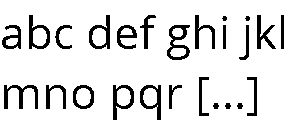

In [586]:
t.image

In [493]:
t.dimensions

(274, 157)

In [92]:
artistY = e.height-t.dimensions[1]
artistX = e.width-artistY
artistX, artistY

(269, 331)

In [583]:
a = TextBlock(text="abc def ghi jkl mno pqr stu vwx 123 456 789 ABC DEF GHI", resolution=(400, 90), size=34, coordinates=(200, 270), max_lines=2, center=False)

DEBUG:root:maximum characters/line: 21
DEBUG:root:total lines: 2
DEBUG:root:['abc def ghi jkl mno', 'pqr stu vwx 123 [...]']
DEBUG:root:text dimension: (308, 90)


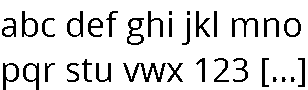

In [584]:
a.image

In [570]:
ca = CoverArt('./cover.jpg', resolution=(180, 180), coordinates=(10, 114))

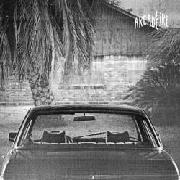

In [413]:
ca.image

In [66]:
e = epd5in83.EPD()

In [76]:
e.width, e.height

(600, 448)

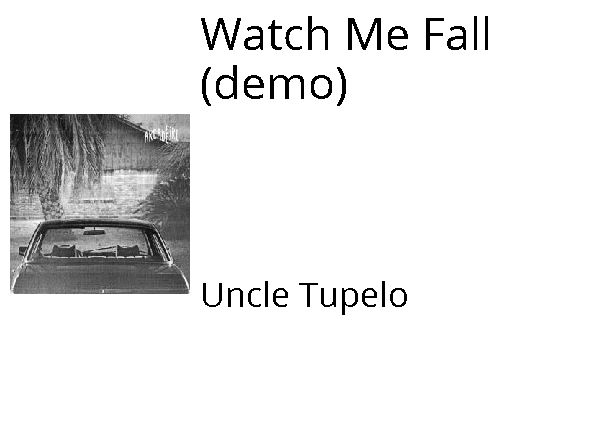

In [581]:
s = Screen(elements=[t, ca, a])
s.concat()

In [582]:
s.epd = epd5in83.EPD()
s.initEPD()
# s.clearEPD()
s.writeEPD()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:imwidth = 600  imheight =  448 
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:spi end
DEBUG:root:close 5V, Module enters 0 power consumption ...


In [165]:
s.initEPD()
s.clearEPD()

DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
DEBUG:root:e-Paper busy
DEBUG:root:e-Paper busy release
